In [1]:
from faker import Faker
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 

In [2]:
fake = Faker()

In [3]:
nrow = 100000

In [4]:
df = pd.DataFrame()

In [5]:
# create an id and pol_ref field
df['id'] = range(1, nrow+1)
df['pol_ref']= 'pol'+ str(random.randint(0,99)).zfill(5) + df['id'].astype(str)

In [6]:
# add customer information
df['name'] = [fake.name()
              for _ in range(nrow)]
df['address'] = [fake.address()
              for _ in range(nrow)]

In [7]:
# numeric data
df['age'] = np.random.randint(17, 91, nrow)
df['licence_length'] = np.random.randint(0, 10, nrow)
df['car_year'] = np.random.randint(1998, 2021, nrow)
df['postcode_rating'] = np.random.randint(1, 50, nrow)
#df['age'] = np.random.gamma(shape, scale, nrow)

In [8]:
# # Text data

# df['text1'] = [fake.sentence(nb_words=10, variable_nb_words=True)
#                for _ in range(nrow)]
# df['text2'] = [fake.sentence(nb_words=4, variable_nb_words=True)
#                for _ in range(nrow)]

In [9]:
# Categorical data

df['car_make'] = np.random.choice(['Audi', 'BMW', 'Ford', 'Jaguar'], nrow, p=[0.25, 0.25, 0.4, 0.1])
df['car_body_type'] = np.random.choice(['Hatchback', 'SUV', 'Sport'], nrow, p=[0.5, 0.45, 0.05])
df['car_modified_indicator'] = np.random.choice(['Yes', 'No'], nrow, p=[0.99, 0.01])
df['car_engine_capacity'] = np.random.choice(['1.0', '2.0', '3.0'], nrow, p=[0.5, 0.45, 0.05])
df['car_top_speed'] = np.random.choice(['120', '155', '200'], nrow, p=[0.7, 0.25, 0.05])
# acceleration

In [10]:
# df['datetime1'] = [fake.date_time_between(
#     start_date=datetime(2017, 1, 1),
#     end_date=datetime(2018, 12, 31))
#     for _ in range(nrow)]
# df['datetime2'] = df['datetime1'].apply(lambda x: x +
#                                         pd.Timedelta(seconds=np.random.randint(0, 72 * 60 * 60)))


In [11]:
# Process each generated field to derive a target statistic.

from collections import Counter

def text1_transform(text):
    text_split = text.split(" ")
    num_words = len(text_split)

    total = 0
    for i, word in enumerate(text_split):
        total += np.power(len(word), 1 + i / 100) / num_words

    return total


def text2_transform(text):
    counts = Counter(text)
    return sum([counts.get(x, 0) for x in 'aeiou'])

def datetime2_transform(datetime_col):
    hour = datetime_col.dt.hour
    dayofweek = datetime_col.dt.dayofweek
    year = datetime_col.dt.year

    hour_tf = np.array([0.1 if x <= 6 or x >= 20 else 0.3 for x in hour])
    dayofweek_tf = np.array([0.2 if x >= 5 else 0.5 for x in dayofweek])
    year_tf = np.array([0.2 if x == 2017 else 0.5 for x in year])

    return hour_tf + dayofweek_tf + year_tf

def cat1_transform(key):
    return cat1_dict[key]


def cat2_transform(key):
    return cat2_dict[key]

In [40]:
# num1_tf = df['age']**2 
# num2_tf = df['licence_length'] / 10 * num1_tf 

num1_tf = (df['age'])*1 + df['licence_length'] + (1/df['postcode_rating'])

cat1_dict = {
    'Hatchback': 1,
    'SUV': 1,
    'Sport': 15
}

cat2_dict = {
    'Yes': 99,
    'No': 1,
}

cat1_tf=df['car_body_type'].apply(cat1_transform)
cat2_tf=df['car_modified_indicator'].apply(cat2_transform)


df['target'] = num1_tf + cat1_tf + cat2_tf
#                 np.power(text1_tf * text2_tf, datetime2_tf) +
#                 datetime1_tf 

In [41]:
df['target'] = np.where(df['target'] <= np.percentile(df['target'], 12), 1, 0)
df['exposure'] = 1

In [42]:
df.head()

,id,pol_ref,name,address,age,licence_length,car_year,postcode_rating,car_make,car_body_type,car_modified_indicator,car_engine_capacity,car_top_speed,target,exposure
0,1,pol000251,Kevin Henry,"4762 Michelle Lodge Suite 470\nSusanmouth, NH ...",65,8,2015,36,BMW,Hatchback,Yes,1.0,120,0,1
1,2,pol000252,William Miller,"35846 Maynard Run Suite 001\nSouth John, OK 11375",60,2,2017,3,Audi,SUV,Yes,2.0,120,0,1
2,3,pol000253,Scott Guerrero,"70047 Mora Mission\nPort Paul, ME 52427",49,7,2010,25,Jaguar,Hatchback,Yes,1.0,155,0,1
3,4,pol000254,Adam Butler,"248 Justin Glen\nNorth Amy, NM 75562",85,7,2007,28,Ford,Hatchback,Yes,1.0,120,0,1
4,5,pol000255,Jenny Carpenter,"PSC 0358, Box 6831\nAPO AP 75397",54,7,2007,12,Ford,SUV,Yes,1.0,155,0,1


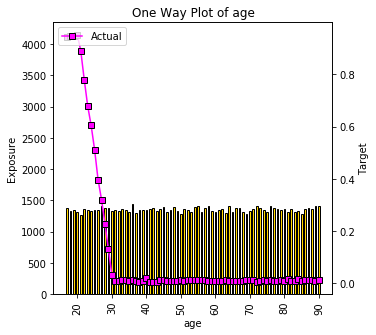

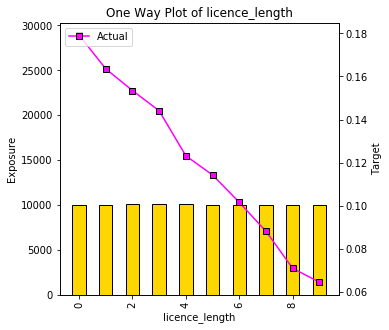

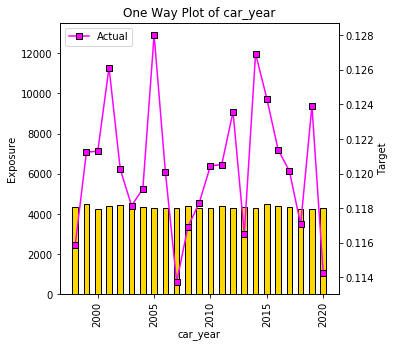

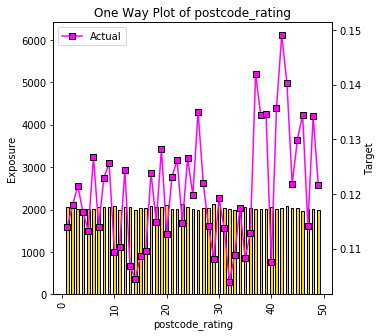

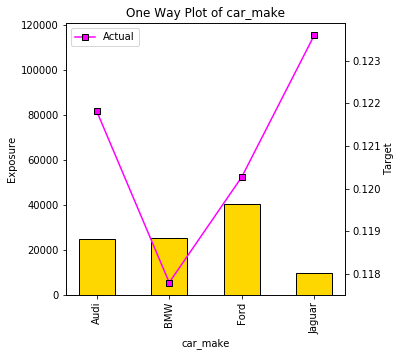

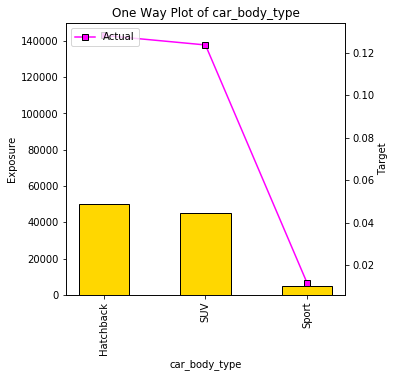

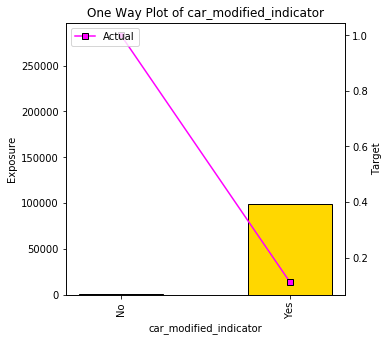

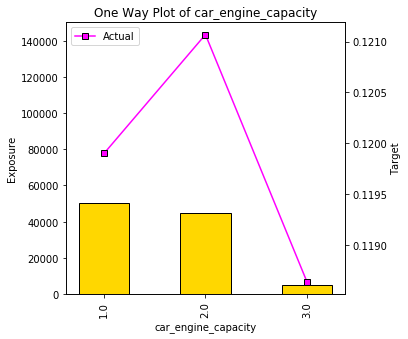

In [43]:
cols=['age', 
      'licence_length', 
      'car_year', 
      'postcode_rating', 
      'car_make', 
      'car_body_type', 
      'car_modified_indicator', 
      'car_engine_capacity']

for i in cols:

    # values for x-graph
    exposure=df.groupby(i)['exposure'].sum()
    obs=df.groupby(i)['target'].mean()
    diff_band=sorted(set(df[i]))

    # Bar plot
    plt.rcParams["figure.figsize"] = (5,5)
    width = 0.5
    plt.bar(diff_band, exposure, width, color='gold', label='Diff', edgecolor='k')
    plt.xticks(rotation=90)
    plt.ylim(0, max(exposure)*3)
    plt.ylabel('Exposure')
    plt.xlabel(f'{i}')
    plt.title(f'One Way Plot of {i}')

    # Line plot
    axes2 = plt.twinx()
    axes2.plot(diff_band, obs, color='fuchsia', marker="s", markeredgecolor='black', label='Actual')
    # axes2.plot(diff_band, prop, color='blue', marker="D", markeredgecolor='black', label=f'Model 2 ({model2})')
    # axes2.plot(diff_band, curr, color='g', marker="^", markeredgecolor='black', label=f'Model 1 ({model1})')
    axes2.set_ylabel('Target')

    # legend and settings
    plt.legend(loc="upper left")

    plt.show()